# Time series forecasting

# Initial setup

## Import required packages

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Import time series data: Airline passenger traffic

In [3]:
data = pd.read_csv('Temperature2.csv')
data['Month'] = pd.to_datetime(data['Year-Month'], format='%Y-%m')
data = data.set_index('Month')
data.head(12)

,year,month,Year-Month,Temperature
Month,,,,
2015-01-01,2015,1,2015-1,-0.2
2015-02-01,2015,2,2015-2,1.2
2015-03-01,2015,3,2015-3,4.6
2015-04-01,2015,4,2015-4,9.9
2015-05-01,2015,5,2015-5,15.1
2015-06-01,2015,6,2015-6,18.1
2015-07-01,2015,7,2015-7,22.8
2015-08-01,2015,8,2015-8,23.6
2015-09-01,2015,9,2015-9,19.4


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2015-01-01 to 2019-12-01
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         60 non-null     int64  
 1   month        60 non-null     int64  
 2   Year-Month   60 non-null     object 
 3   Temperature  60 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.3+ KB


In [6]:
data = data.drop(['year', 'month', 'Year-Month'], axis = 1) 
data.head()

,Temperature
Month,
2015-01-01,-0.2
2015-02-01,1.2
2015-03-01,4.6
2015-04-01,9.9
2015-05-01,15.1


# Time series analysis

## Plot time series data

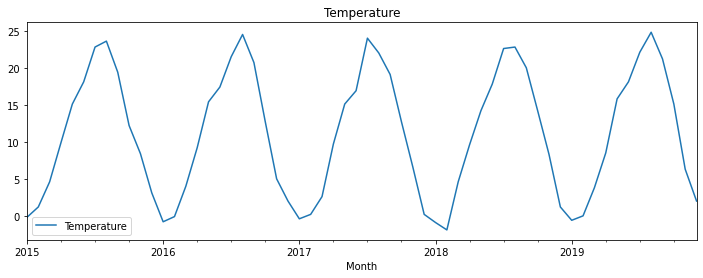

In [7]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Temperature')
plt.show(block=False)

## Outlier detection

### Box plot and interquartile range

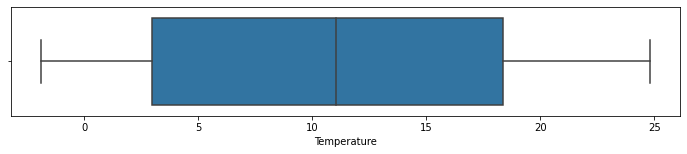

In [8]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['Temperature'],whis=1.5)

### Histogram plot

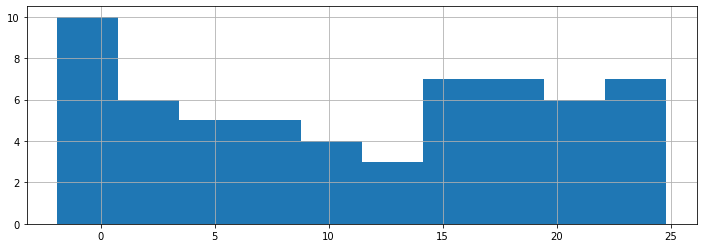

In [9]:
fig = data.Temperature.hist(figsize = (12,4))

## Time series Decomposition

### Additive seasonal decomposition

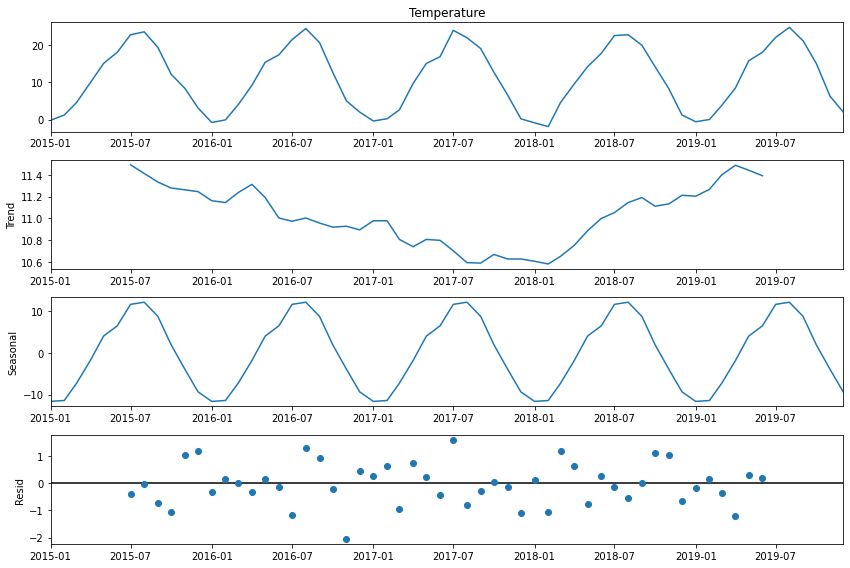

In [10]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.Temperature, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

# Build and evaluate time series forecast

## Split time series data into training and test set

In [12]:
train_len = 43
train = data[0:train_len] # first 43 months as training set
test = data[train_len:] # last 17 months as out-of-time test set

In [13]:
train.shape

(43, 1)

In [14]:
test.shape

(17, 1)

# Simple time series methods

## Naive method

In [15]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Temperature'][train_len-1]

### Plot train, test and forecast

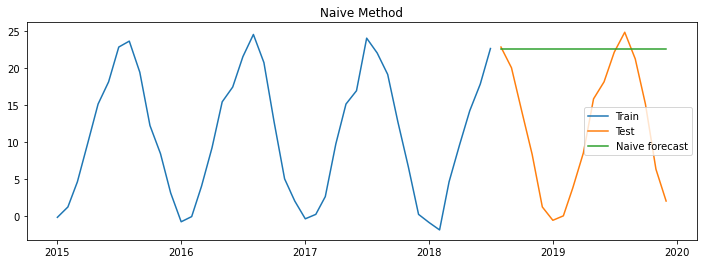

In [16]:
plt.figure(figsize=(12,4))
plt.plot(train['Temperature'], label='Train')
plt.plot(test['Temperature'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

### Calculate RMSE and MAPE

In [17]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Temperature'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Temperature']-y_hat_naive['naive_forecast'])/test['Temperature'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,13.64,inf


## Simple moving average method

In [18]:
y_hat_sma = data.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = data['Temperature'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

### Plot train, test and forecast

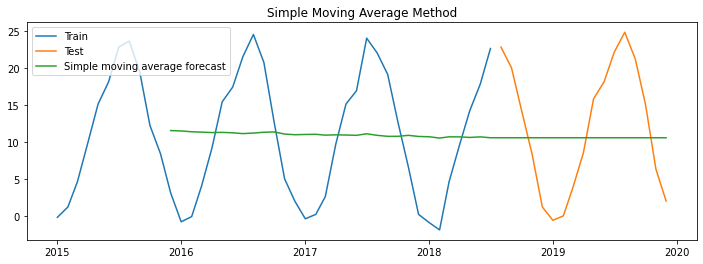

In [19]:
plt.figure(figsize=(12,4))
plt.plot(train['Temperature'], label='Train')
plt.plot(test['Temperature'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [20]:
rmse = np.sqrt(mean_squared_error(test['Temperature'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Temperature']-y_hat_sma['sma_forecast'][train_len:])/test['Temperature'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,13.64,inf
0,Simple moving average forecast,8.67,inf


# Exponential smoothing methods

## Holt's Method with Trend

In [22]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Temperature']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.9354289739828777, 'smoothing_slope': 0.9999064477473765, 'smoothing_seasonal': nan, 'damping_slope': nan, 'initial_level': 0.009355225262355013, 'initial_slope': 1.3097315367297018, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

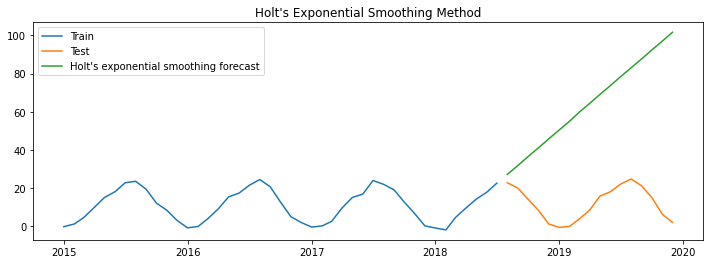

In [23]:
plt.figure(figsize=(12,4))
plt.plot( train['Temperature'], label='Train')
plt.plot(test['Temperature'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

### Calculate RMSE and MAPE

In [26]:
rmse = np.sqrt(mean_squared_error(test['Temperature'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Temperature']-y_hat_holt['holt_forecast'])/test['Temperature'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,13.64,inf
0,Simple moving average forecast,8.67,inf
0,Holt's exponential smoothing method,57.76,inf


## Holt Winters' additive method with trend and seasonality

In [28]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Temperature']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.05263157894736842, 'smoothing_slope': 0.05263157894736842, 'smoothing_seasonal': 0.2631578947368421, 'damping_slope': nan, 'initial_level': 0.01, 'initial_slope': 0.01, 'initial_seasons': array([ 0.375,  1.775,  5.175, 10.475, 15.675, 18.675, 23.375, 24.175,
       19.975, 12.775,  8.975,  3.675]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


### Plot train, test and forecast

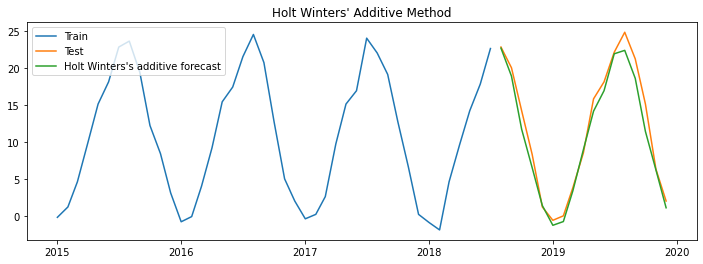

In [29]:
plt.figure(figsize=(12,4))
plt.plot( train['Temperature'], label='Train')
plt.plot(test['Temperature'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

### Calculate RMSE and MAPE

In [30]:
rmse = np.sqrt(mean_squared_error(test['Temperature'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Temperature']-y_hat_hwa['hw_forecast'])/test['Temperature'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,13.64,inf
0,Simple moving average forecast,8.67,inf
0,Holt's exponential smoothing method,57.76,inf
0,Holt Winters' additive method,1.61,inf


### Holt Winters' additive method with trend and seasonality - 50:10

In [35]:
train_len = 50
train = data[0:train_len] # first 50 months as training set
test = data[train_len:] # last 10 months as out-of-time test set

In [36]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Temperature']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.10526248035979094, 'smoothing_slope': 0.10526891694177695, 'smoothing_seasonal': 0.3157897190278576, 'damping_slope': nan, 'initial_level': 0.00999993563418014, 'initial_slope': 0.00999993563418014, 'initial_seasons': array([ 0.37999742,  1.77998013,  5.17999359, 10.48000078, 15.680006  ,
       18.67999644, 23.3800047 , 24.18000274, 19.98001798, 12.78002136,
        8.97997432,  3.67997704]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

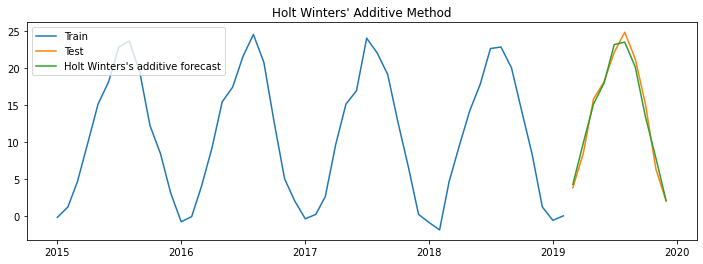

In [37]:
plt.figure(figsize=(12,4))
plt.plot( train['Temperature'], label='Train')
plt.plot(test['Temperature'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

### Calculate RMSE and MAPE

In [38]:
rmse = np.sqrt(mean_squared_error(test['Temperature'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Temperature']-y_hat_hwa['hw_forecast'])/test['Temperature'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method-50:10'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,13.64,inf
0,Simple moving average forecast,8.67,inf
0,Holt's exponential smoothing method,57.76,inf
0,Holt Winters' additive method,1.61,inf
0,Holt Winters' additive method-50:10,1.08,8.59


In [39]:
data = pd.read_csv('Exchange+Rate+1.csv')
data['Month'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data = data.set_index('Month')
data.head(12)

,Date,Exchange Rate
Month,,
2019-08-12,12-08-2019,0.8919
2019-08-13,13-08-2019,0.8943
2019-08-14,14-08-2019,0.8973
2019-08-15,15-08-2019,0.9004
2019-08-16,16-08-2019,0.9016
2019-08-19,19-08-2019,0.9012
2019-08-20,20-08-2019,0.9016


In [40]:
data = data.drop(['Date'], axis=1)
data

,Exchange Rate
Month,
2019-08-12,0.8919
2019-08-13,0.8943
2019-08-14,0.8973
2019-08-15,0.9004
2019-08-16,0.9016
2019-08-19,0.9012
2019-08-20,0.9016


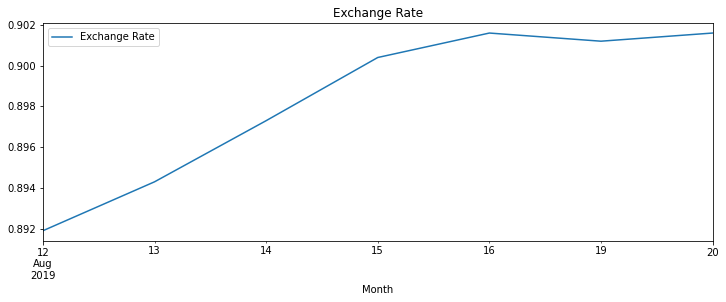

In [41]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Exchange Rate')
plt.show(block=False)

In [42]:
train_len = 5
train = data[0:train_len] # first 5 months as training set
test = data[train_len:] # last 2 months as out-of-time test set

# Simple time series methods

## Naive method

In [48]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Exchange Rate'][train_len-1]

### Plot train, test and forecast

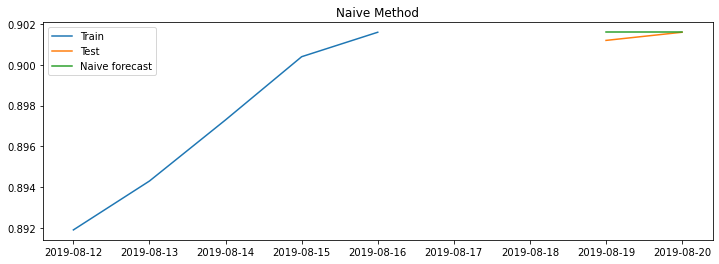

In [46]:
plt.figure(figsize=(12,4))
plt.plot(train['Exchange Rate'], label='Train')
plt.plot(test['Exchange Rate'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

In [50]:
y_hat_naive['naive_forecast']

Month
2019-08-19    0.9016
2019-08-20    0.9016
Name: naive_forecast, dtype: float64

### Calculate RMSE and MAPE

In [49]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Exchange Rate'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate']-y_hat_naive['naive_forecast'])/test['Exchange Rate'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,0.0,0.02


## Simple moving average method

In [51]:
y_hat_sma = data.copy()
ma_window = 1
y_hat_sma['sma_forecast'] = data['Exchange Rate'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

### Plot train, test and forecast

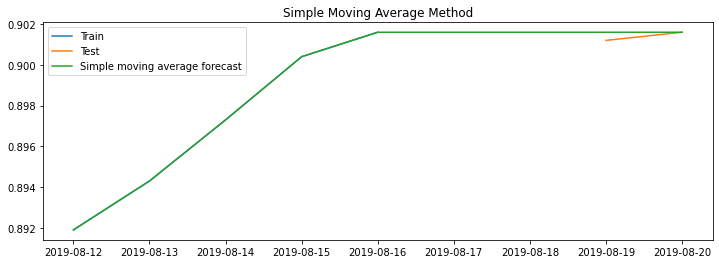

In [52]:
plt.figure(figsize=(12,4))
plt.plot(train['Exchange Rate'], label='Train')
plt.plot(test['Exchange Rate'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [53]:
rmse = np.sqrt(mean_squared_error(test['Exchange Rate'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate']-y_hat_sma['sma_forecast'][train_len:])/test['Exchange Rate'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,0.0,0.02
0,Simple moving average forecast,0.0,0.02


In [54]:
y_hat_sma['sma_forecast']

Month
2019-08-12    0.8919
2019-08-13    0.8943
2019-08-14    0.8973
2019-08-15    0.9004
2019-08-16    0.9016
2019-08-19    0.9016
2019-08-20    0.9016
Name: sma_forecast, dtype: float64

### Simple Average Forecast

In [55]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Exchange Rate'].mean()

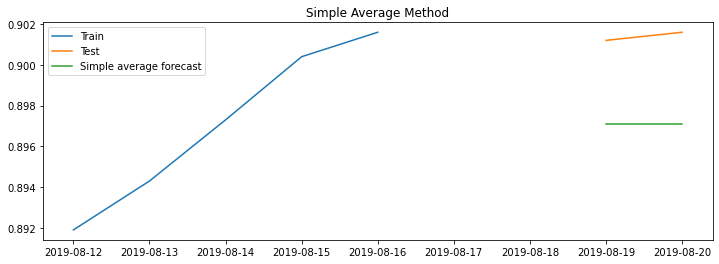

In [57]:
# Plot

plt.figure(figsize=(12,4))
plt.plot(train['Exchange Rate'], label='Train')
plt.plot(test['Exchange Rate'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

In [58]:
rmse = np.sqrt(mean_squared_error(test['Exchange Rate'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate']-y_hat_avg['avg_forecast'])/test['Exchange Rate'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,0.0,0.02
0,Simple moving average forecast,0.0,0.02
0,Simple average method,0.0,0.48


In [59]:
y_hat_avg['avg_forecast']

Month
2019-08-19    0.8971
2019-08-20    0.8971
Name: avg_forecast, dtype: float64

In [60]:
data = pd.read_csv('Exchange+Rate+2.csv')
data['Month'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data = data.set_index('Month')
data.head(12)

,Date,Exchange Rate
Month,,
2019-03-01,01-03-2019,0.8790
2019-03-04,04-03-2019,0.8828
2019-03-05,05-03-2019,0.8850
2019-03-06,06-03-2019,0.8834
2019-03-07,07-03-2019,0.8917
2019-03-08,08-03-2019,0.8894
2019-03-11,11-03-2019,0.8908
2019-03-12,12-03-2019,0.8868
2019-03-13,13-03-2019,0.8842


In [61]:
data = data.drop(['Date'], axis=1)
data

,Exchange Rate
Month,
2019-03-01,0.8790
2019-03-04,0.8828
2019-03-05,0.8850
2019-03-06,0.8834
2019-03-07,0.8917
2019-03-08,0.8894
2019-03-11,0.8908
2019-03-12,0.8868
2019-03-13,0.8842


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43 entries, 2019-03-01 to 2019-04-30
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Exchange Rate  43 non-null     float64
dtypes: float64(1)
memory usage: 688.0 bytes


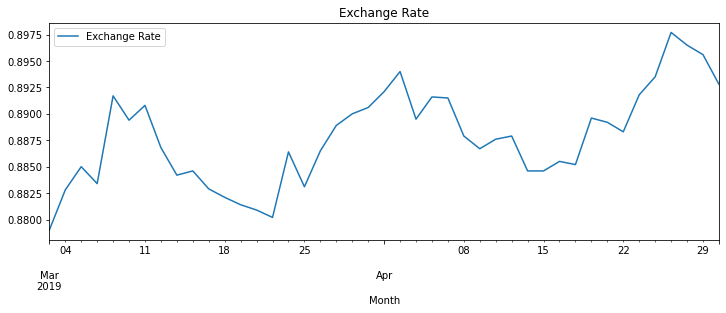

In [63]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Exchange Rate')
plt.show(block=False)